# Extract Electron Power from Images

In [1]:
from pathlib import Path
import numpy as np
import pyclesperanto as cle
import matplotlib.pyplot as plt

import vprd

# figure parameters
plt.rcParams['svg.fonttype'] = 'none'  # makes text editable in svg
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

# figure sizes
textwidth = 7.05  # inches
onecolumn = 3.42  # inches
# set the default figure size to one column width
plt.rcParams['figure.figsize'] = (onecolumn, onecolumn)

## Load the data

In [2]:
data_path = Path('../../data')
local_data_path = Path(data_path / 'cloud/')
data_file = local_data_path / 'PBD2_VRFD_pbd2_stream_6_run52040_file114_20240227T153103.hdf5'

#load the images
df = vprd.hdf5_to_df(data_file)
images = list(df['Images'])

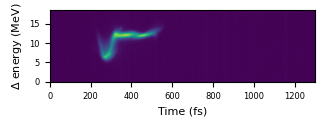

In [3]:
index = 10
vprd.image_processing.show_phase_image(images[index])

In [4]:
charges = list(df['/FLASH_DIAG/TOROID/7FL2XTDS/CHARGE_TD'])
charges[index]

0.19830000400543213

## Extract electron power

### Project electron power onto time axis

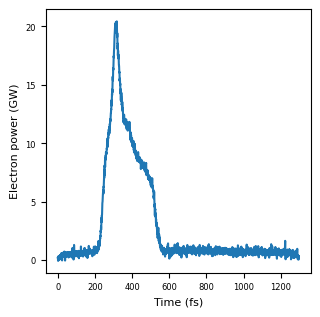

In [5]:
projected_electron_power = vprd.image_processing.calculate_electron_power(vprd.image_processing.destripe_image(images[index]), charges[index])
_ = vprd.image_processing.calibrated_lineplot(projected_electron_power / 1e9, 'Electron power (GW)' )

### Concatenate all projected powers into a 2D array

(706, 2360)

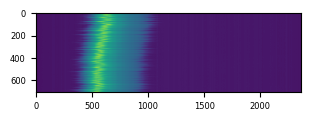

In [6]:

power = np.array([vprd.image_processing.calculate_electron_power(vprd.image_processing.destripe_image(img.astype(np.float32)), charge)
                       for img, charge in zip(images, charges)])
plt.imshow(power)
power.shape

## De-jittering

### Identify peaks

#### Denoise along the time axis

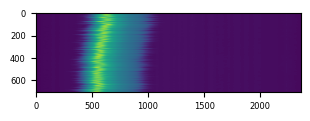

In [7]:
blurred = cle.gaussian_blur(power, sigma_x=10.0, sigma_y=0.0)
_ = plt.imshow(blurred)

#### Peaks are the mode of the denoised data

In [8]:
peaks = np.array([np.argmax(row) for row in blurred])
median_peak_location = int(np.median(peaks))
median_peak_location

567

### Calculate offset of each peak relative to the median of all peaks

In [9]:
offsets = peaks - median_peak_location
print(f"Minimum offset: {np.min(offsets)}, maximum offset: {np.max(offsets)}")

Minimum offset: -120, maximum offset: 124


### Move peaks according to the offset

(np.float32(-0.741802), np.float32(23.495594))

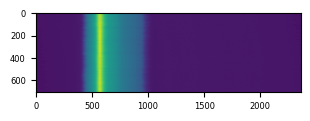

In [10]:
aligned_power = np.array([np.roll(row, -offset) for row, offset in zip(power, offsets)])
plt.imshow(aligned_power)
aligned_power.min() / 1e9, aligned_power.max() / 1e9 # min and max in GW

## Cropping out the signal

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8, mtype=buffer)
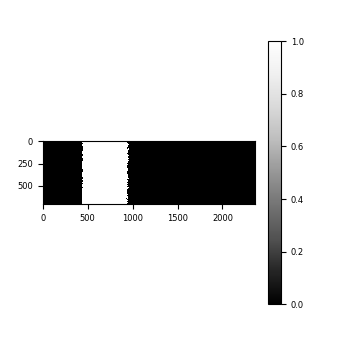
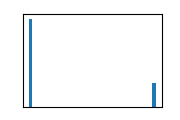

In [11]:
thresholded = cle.threshold_otsu(aligned_power)
thresholded

In [12]:
bounding_box = [int(v) for v in cle.bounding_box(thresholded)]
bounding_box

[422, 0, 0, 962, 705, 0]

(706, 560)

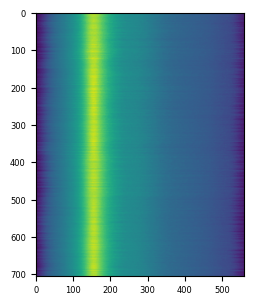

In [13]:
padding = 10
cropped_power = aligned_power[:, int(bounding_box[0]) - padding:int(bounding_box[3]) + padding]
plt.imshow(cropped_power)
cropped_power.shape

## De-jittering figure

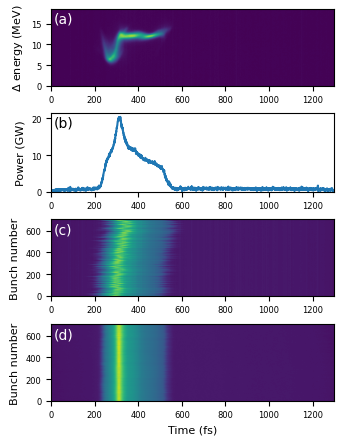

In [14]:
from matplotlib import transforms
import seaborn as sns
fig, axs = plt.subplots((4), figsize=(onecolumn, onecolumn * 1.3))
vprd.image_processing.show_phase_image(images[index], ax=axs[0])
# put title in the top left corner
axs[0].set_title('(a)', x=0.008, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'], color='white')

# plot power profile
vprd.image_processing.calibrated_lineplot(projected_electron_power / 1e9, 'Power (GW)', ax=axs[1])
axs[1].set_title('(b)', x=0.008, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'])
axs[1].set_xlim(0, vprd.data.pixels_to_fs(len(projected_electron_power)))
axs[1].set_ylim(0, axs[1].get_ylim()[1])

max_time = vprd.data.pixels_to_fs(images[index].shape[1])
aspect_ratio = 0.4975
extent = [0, max_time, 0, len(images)]
axs[2].imshow(power, aspect = aspect_ratio, extent=extent)
axs[2].set_xlabel('Time (fs)')
axs[2].set_ylabel('Bunch number')
axs[2].set_title('(c)', x=0.008, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'], color='white')

axs[3].imshow(aligned_power, aspect = aspect_ratio, extent=extent)
axs[3].set_title('(d)', x=0.008, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'], color='white')
axs[3].set_xlabel('Time (fs)')
axs[3].set_ylabel('Bunch number')


# hide the x-axis labels for the first three plots
for ax in axs[:-1]:
    ax.set_xlabel('')

fig.tight_layout()

fig.savefig(local_data_path / 'de-jittering.svg', bbox_inches='tight')